NOTEBOOK - LIMPIO

1 - IMPORTAMOS LIBRERIAS Y LEEMOS LOS DATOS

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as pl
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pl.offline.init_notebook_mode(connected=True)

propiedades= pd.read_csv(r'C:\Users\Matías\Documents\DH\properatti.csv')

COMENZAMOS CON LA LIMPIEZA DE DATOS


In [2]:
#creamos un dataframe nuevo tomando en cuenta solo las propiedades de Capital Federal
propiedades_capital=propiedades.loc[(propiedades.state_name=="Capital Federal")]
propiedades_capital.state_name.value_counts()

Capital Federal    32316
Name: state_name, dtype: int64

In [3]:
#creamos una serie dummy para saber el tipo de cambio utilizado a la fecha del registro
#SOLO DE MANERA INFORMATIVA
dummy=propiedades_capital['price_aprox_local_currency']/propiedades_capital['price_aprox_usd']
tasa_cambio=dummy.mean()
tasa_cambio

17.644499993856833

In [4]:
#chequeamos la cantidad de valores faltantes en la columna price_usd_per_m2
#nos interesa ese campo ya que el precio en moneda local está sujeto a una tasa de cambio muy volatil 
#o inestables en el tiempo (tenemos la tasa de cambio a la fecha que se creo el DF pero no cuando se grabaron los datos 
#de cada propiedad), en este caso nos guiaremos por el valor en USD$ y el area o superficie de la propiedad
propiedades_capital.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
dtype: int64

In [5]:
#Columnas con pocos valores
i=0
for label, content in propiedades_capital.iteritems():
    num=len(pd.unique(propiedades_capital.iloc[:,i]))
    porcentaje=float(num)/propiedades_capital.shape[0]*100
    print("%s, %d, %.1f%%"%(label,num,porcentaje))
    propiedades_capital.iteritems()
    i=i+1


Unnamed: 0, 32316, 100.0%
operation, 1, 0.0%
property_type, 4, 0.0%
place_name, 62, 0.2%
place_with_parent_names, 62, 0.2%
country_name, 1, 0.0%
state_name, 1, 0.0%
geonames_id, 53, 0.2%
lat-lon, 14161, 43.8%
lat, 13885, 43.0%
lon, 13900, 43.0%
price, 5205, 16.1%
currency, 4, 0.0%
price_aprox_local_currency, 5295, 16.4%
price_aprox_usd, 5295, 16.4%
surface_total_in_m2, 751, 2.3%
surface_covered_in_m2, 618, 1.9%
price_usd_per_m2, 10877, 33.7%
price_per_m2, 11747, 36.4%
floor, 86, 0.3%
rooms, 19, 0.1%
expenses, 755, 2.3%
properati_url, 32316, 100.0%
description, 26094, 80.7%
title, 18144, 56.1%
image_thumbnail, 30255, 93.6%


In [6]:
#Observamos si hay filas duplicadas y de ser asi las eliminamos
duplicado = propiedades_capital.duplicated()
print(duplicado.any())
print(propiedades_capital[duplicado])
print(propiedades.shape)
propiedades.drop_duplicates(inplace=True)
print(propiedades.shape)

False
Empty DataFrame
Columns: [Unnamed: 0, operation, property_type, place_name, place_with_parent_names, country_name, state_name, geonames_id, lat-lon, lat, lon, price, currency, price_aprox_local_currency, price_aprox_usd, surface_total_in_m2, surface_covered_in_m2, price_usd_per_m2, price_per_m2, floor, rooms, expenses, properati_url, description, title, image_thumbnail]
Index: []

[0 rows x 26 columns]
(121220, 26)
(121220, 26)


In [7]:
#creamos una serie nueva tomando el promedio del m2 en dolares con respecto al barrio (lo usaremos posteriormente para llenas los NaN)

pricem2USD_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
pricem2USD_fill_values

place_name
Abasto              2057.529147
Agronomía           2088.124134
Almagro             2749.102521
Balvanera           1982.249390
Barracas            1969.946866
                       ...     
Villa Riachuelo     1110.690766
Villa Santa Rita    1889.186620
Villa Soldati        743.666758
Villa Urquiza       2495.288265
Villa del Parque    2233.837905
Name: price_usd_per_m2, Length: 62, dtype: float64

In [8]:
#creamos un dataFrame nuevo con los valores de la serie obtenida anteriormente y hacemos un merge a propiedades_capital2 en una nueva columna 
#con el promedio del m2 en dolares

pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

#usamos fillna para substituir los NaN con los valores en la columna price_usd_per_m2_mean
propiedades_capital2.price_usd_per_m2.fillna(propiedades_capital2.price_usd_per_m2_mean, inplace = True)

In [9]:
#chequeamos que no existan NaN en price_usd_per_m2
propiedades_capital2.price_usd_per_m2.isna().sum()

0

In [10]:
#hacemos un describe la columna price_usd_per_m2
propiedades_capital2.price_usd_per_m2.describe()

count     32316.000000
mean       3040.608512
std        3230.037746
min          13.797467
25%        2000.000000
50%        2495.288265
75%        3153.981976
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [11]:
#removemos los outliers de ese campo
removed_outliers = propiedades_capital2.price_usd_per_m2.between(propiedades_capital2.price_usd_per_m2.quantile(.05), propiedades_capital2.price_usd_per_m2.quantile(.95))

<AxesSubplot:xlabel='Barrios'>

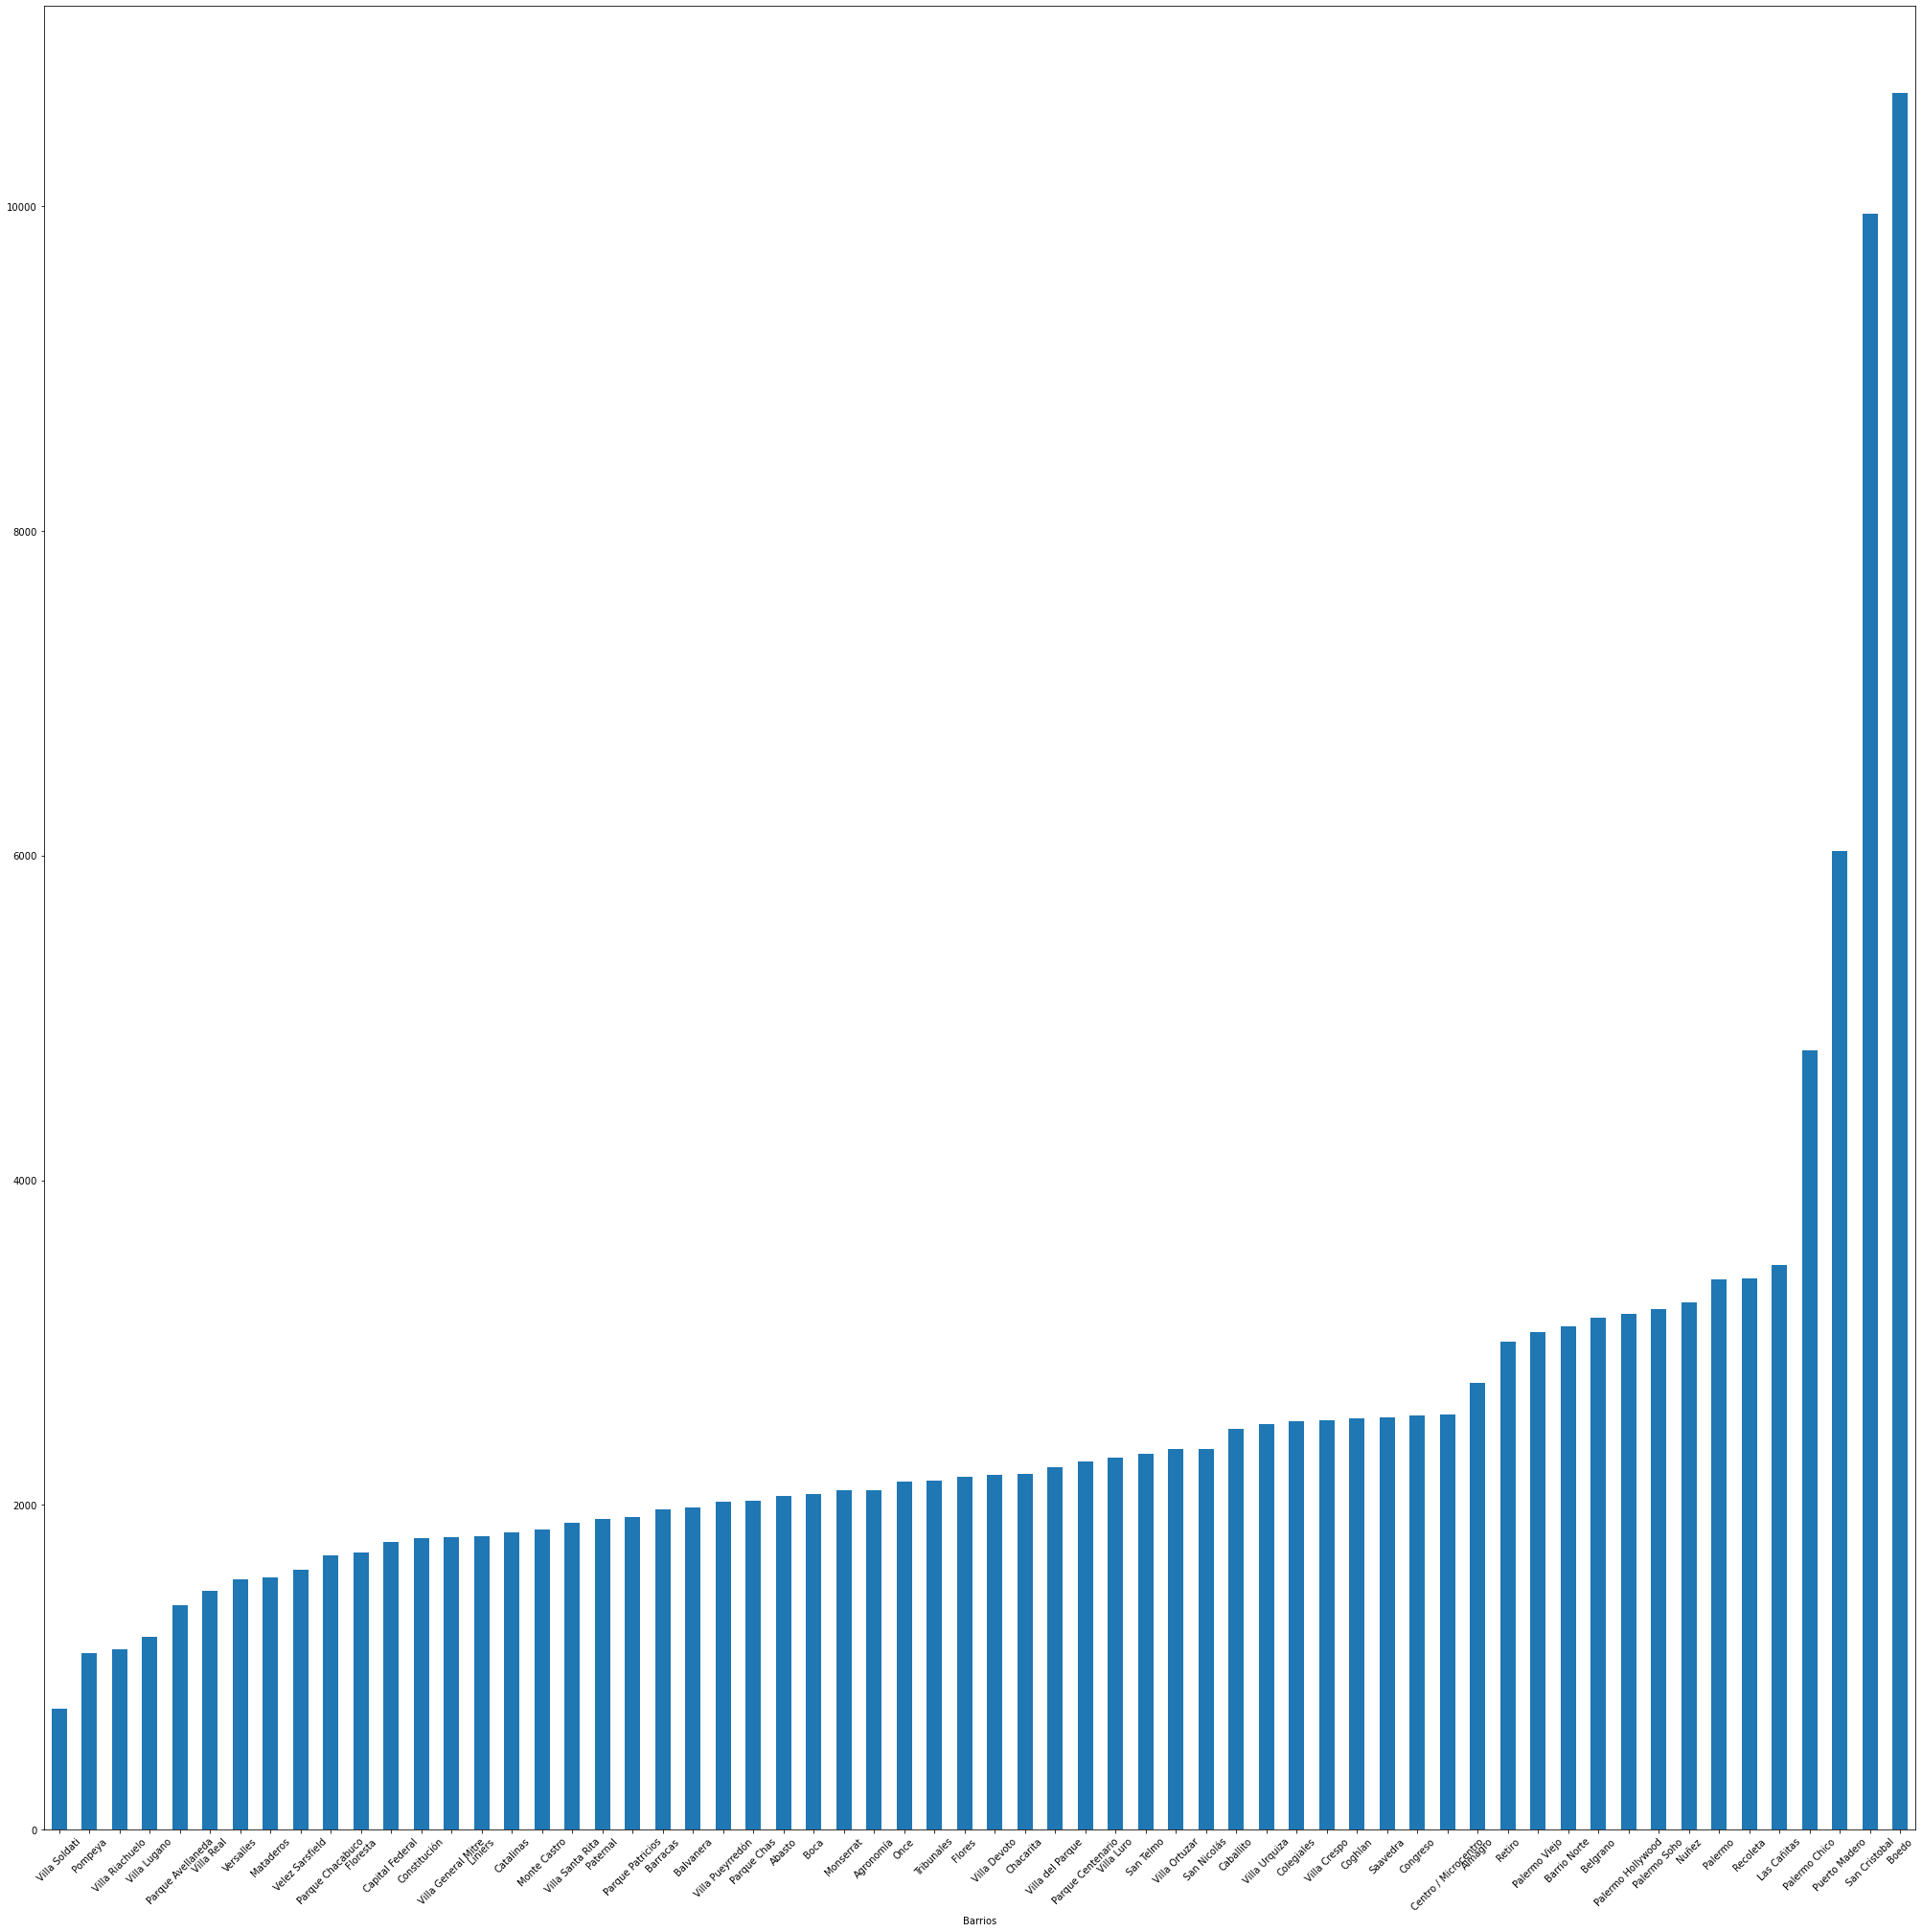

In [12]:
#graficamos el dataframe sin limpiar
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2.groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

<AxesSubplot:xlabel='Barrios'>

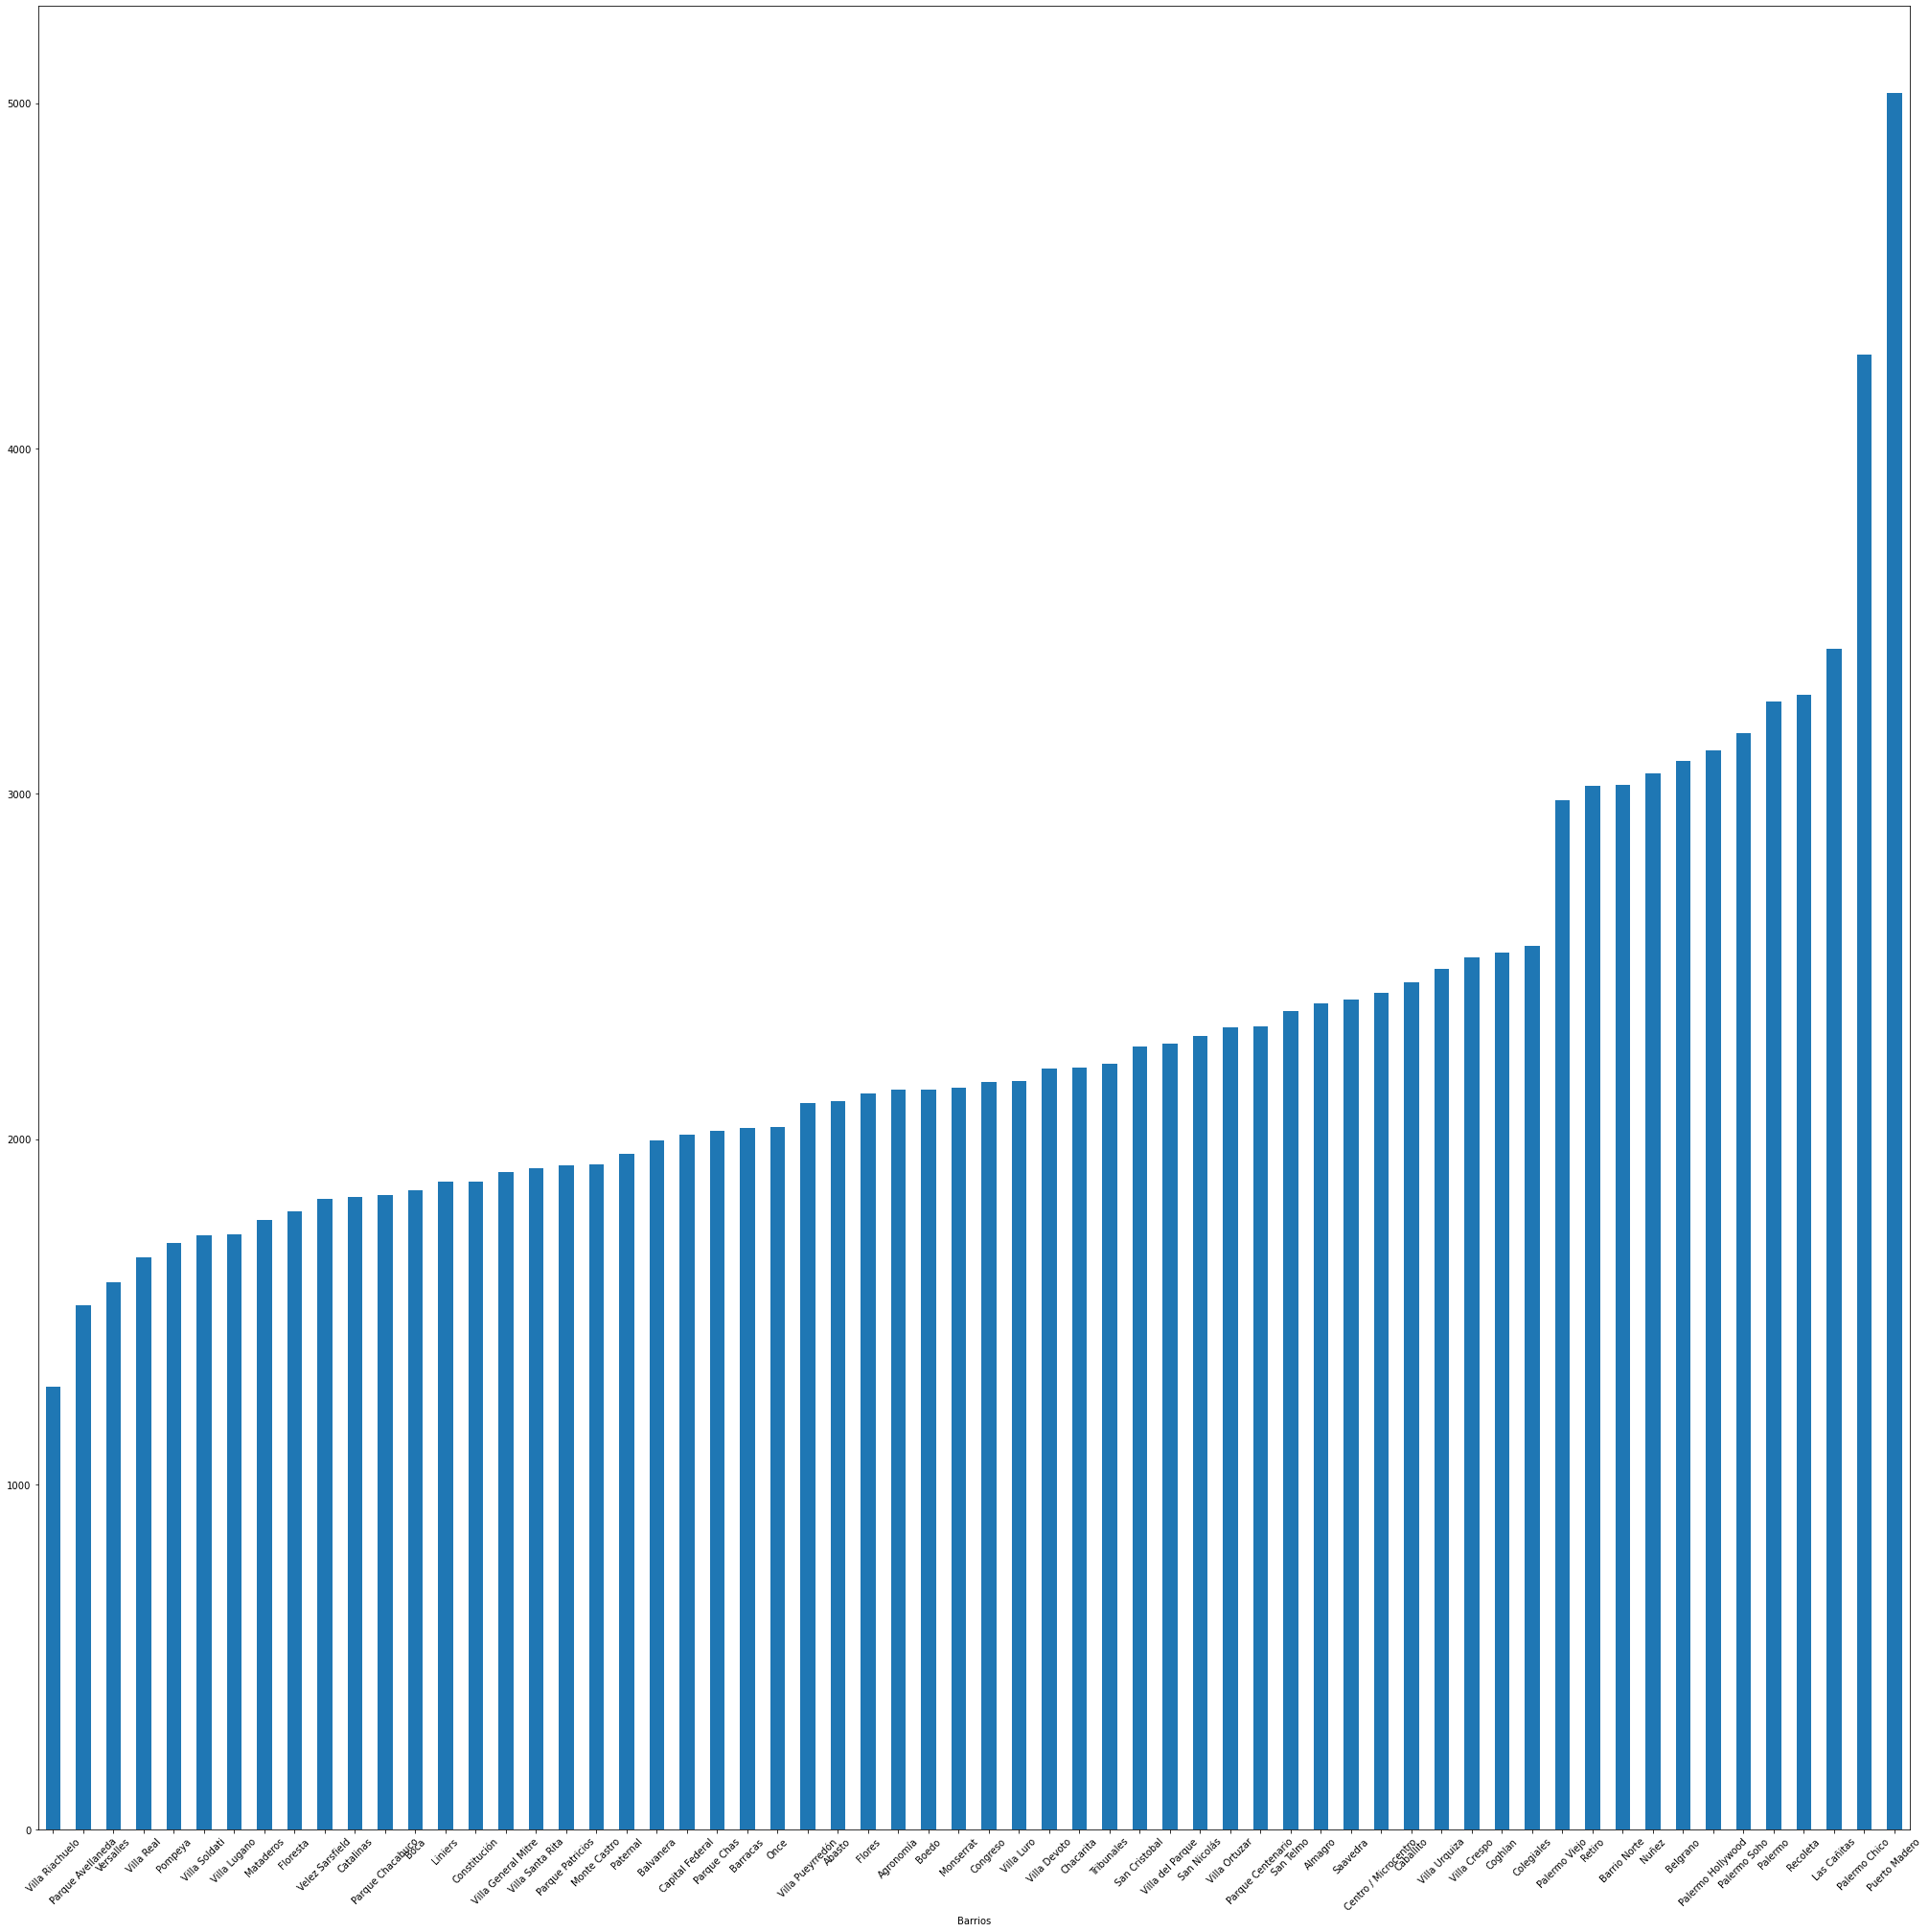

In [13]:
##graficamos el dataframe limpio
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2[removed_outliers].groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

In [14]:
#revisamos cuales otras columnas faltan por datos
propiedades_capital2.isna().sum()


Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2                  0
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
price_usd_per_m2_mean             0
dtype: int64

In [15]:
#observamos que el campo un campo valioso para determinar el precio es el area de la propiedad
#en este caso no podriamos hacer un promedio, procedemos a removerla surface_covered_in_m2
propiedades_capital3=propiedades_capital2.dropna(axis=0,how='any',subset=['surface_covered_in_m2'])
propiedades_capital3.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1218
lat-lon                        7896
lat                            7896
lon                            7896
price                          2651
currency                       2651
price_aprox_local_currency     2651
price_aprox_usd                2651
surface_total_in_m2            5093
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                   2653
floor                         27075
rooms                         15120
expenses                      23825
properati_url                     0
description                       0
title                             0
image_thumbnail                 432
price_usd_per_m2_mean             0
dtype: int64

In [16]:
#funcion para extraer del campo description, el numero de ambientes o habitaciones
def limpieza_description(text):
    try:
        txt="(\d+(?=\s+dorm)|\d(?=\s+amb)|\d(?=\s+hab))"
        txt=txt.lower()
        x=int(re.findall(txt, text)[0])
        
    except IndexError:
        x="1"
    return(x) 

In [17]:
#creamos un df nuevo solo con casas y departamentos para poder limpiar la descripcion
propiedades_capital_casas_dptops=propiedades_capital3.loc[(propiedades_capital3.property_type=="apartment")|(propiedades_capital3.property_type=="house")|(propiedades_capital3.property_type=="PH")]

In [18]:
propiedades_capital3.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [19]:
#creamos el patron REGEX para la busqueda de palabras como "dorm","amb" y "hab". Este patron buscará el primer numero 
#que consiga antes de alguna de esas palabras

pricem2USD_fill_values
propiedades_capital3['rooms_fill']=propiedades_capital3['description'].apply(lambda x: limpieza_description(x))

<ipython-input-19-475f6f71070f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
#propiedades_capital3.columns
propiedades_capital3[['description','rooms','rooms_fill']].sample(5)

,description,rooms,rooms_fill
7676,VENTA DE EXCELENTE PH 3 AMBIENTES EN VILLA URQ...,3.0,1
31586,Casa desarrollada en 3 plantas. PB: amplio liv...,NaN,3
18101,VENTA CON RENTAComplejo Mirabilia. Torre I. Vi...,NaN,3
7048,Depto financiado en 58 meses en pesosPequeo an...,1.0,1
3198,Serrano 300 - VILLA CRESPO - Apto Credito Exce...,3.0,1


In [21]:
#Inputamos los valores Nan de la columna rooms, usando los valores de rooms_fill que obtuvimos de la ultima ejecucion
propiedades_capital3.rooms.fillna(propiedades_capital3.rooms_fill, inplace = True)
propiedades_capital3.dtypes

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                          object
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [22]:
#Seleccionamos las columnas que nos resultan utiles para un modelo posterior
propiedades_capital_limpio=propiedades_capital3[['property_type','place_name','price','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2',
       'surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','description','price_usd_per_m2_mean']]
propiedades_capital_limpio.rooms=propiedades_capital_limpio.rooms.astype(np.float)

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



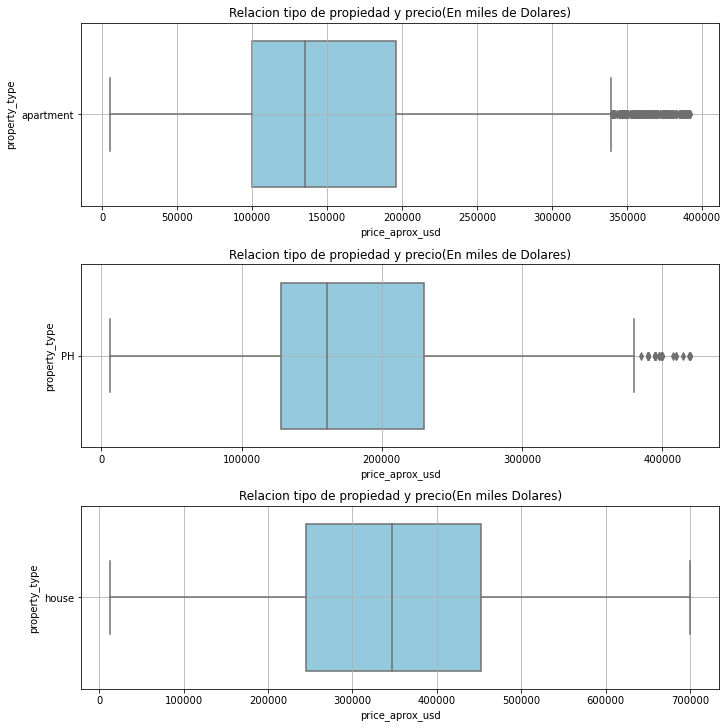

In [23]:
#Utilizamos estos boxplot para analizar la relacion entre los tipos de propiedad y los precios en dolares
propiedades_capital_limpio=propiedades_capital_limpio.dropna(axis=0,how='any',subset=['price_aprox_usd'])
dptos=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="apartment"]
phs=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="PH"]
casas=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="house"]
dptos= dptos[(dptos.price <= 392500.0) & (dptos.price >=65000.0) ]
phs=phs[(phs.price <= 428500.0) & (phs.price >=75000.0) ]
casas=casas[(casas.price <= 706000.0) & (casas.price >=110000.0) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax2.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax3.set_title("Relacion tipo de propiedad y precio(En miles Dolares)")
sns.boxplot(data=dptos,x="price_aprox_usd",y="property_type",ax=ax1, color='skyblue')
sns.boxplot(data=phs,x="price_aprox_usd",y="property_type",ax=ax2, color='skyblue')
sns.boxplot(data=casas,x="price_aprox_usd",y="property_type",ax=ax3, color='skyblue')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [24]:
#porcentaje de valores nulos por columna
col_null_caba=np.sum(propiedades_capital_limpio.isnull())
col_null_caba.sort_values(ascending=False)
porc_nulos_caba=np.round((col_null_caba/propiedades_capital_limpio.shape[0])*100,2)
porc_nulos_caba.sort_values(ascending=False)


floor                         89.54
surface_total_in_m2           18.32
price_per_m2                   0.01
price_usd_per_m2_mean          0.00
description                    0.00
rooms                          0.00
price_usd_per_m2               0.00
surface_covered_in_m2          0.00
price_aprox_usd                0.00
price_aprox_local_currency     0.00
price                          0.00
place_name                     0.00
property_type                  0.00
dtype: float64

In [25]:
propiedades_capital_surface_limpio=propiedades_capital_limpio
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["price_usd_per_m2"]<100000]
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["surface_total_in_m2"]<10000]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="apartment"]
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="house"]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="PH"]
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="store"]

#########################

propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[(propiedades_capital_surface_limpio_casas.surface_total_in_m2 <= 3500) & (propiedades_capital_surface_limpio_casas.surface_total_in_m2 >=30) ]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[(propiedades_capital_surface_limpio_phs.surface_total_in_m2 <= 1000) & (propiedades_capital_surface_limpio_phs.surface_total_in_m2 >=10) ]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[(propiedades_capital_surface_limpio_dptos.surface_total_in_m2 <= 8000) & (propiedades_capital_surface_limpio_dptos.surface_total_in_m2 >=10) ]

#########################

removed_outliers_dptos = propiedades_capital_surface_limpio_dptos.price_usd_per_m2.between(propiedades_capital_surface_limpio_dptos.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_dptos.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[removed_outliers_dptos]

removed_outliers_dptos_area = propiedades_capital_surface_limpio_dptos.surface_total_in_m2.between(propiedades_capital_surface_limpio_dptos.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_dptos.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[removed_outliers_dptos_area]

##########################

removed_outliers_casas = propiedades_capital_surface_limpio_casas.price_usd_per_m2.between(propiedades_capital_surface_limpio_casas.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_casas.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[removed_outliers_casas]

removed_outliers_casas_area = propiedades_capital_surface_limpio_casas.surface_total_in_m2.between(propiedades_capital_surface_limpio_casas.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_casas.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[removed_outliers_casas_area]

###########################

removed_outliers_phs = propiedades_capital_surface_limpio_phs.price_usd_per_m2.between(propiedades_capital_surface_limpio_phs.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_phs.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[removed_outliers_phs]

removed_outliers_phs_area = propiedades_capital_surface_limpio_phs.surface_total_in_m2.between(propiedades_capital_surface_limpio_phs.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_phs.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[removed_outliers_phs_area]


###########################

removed_outliers_stores = propiedades_capital_surface_limpio_stores.price_usd_per_m2.between(propiedades_capital_surface_limpio_stores.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_stores.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio_phs[removed_outliers_phs]

removed_outliers_stores_area = propiedades_capital_surface_limpio_stores.surface_total_in_m2.between(propiedades_capital_surface_limpio_stores.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_stores.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio_stores[removed_outliers_stores_area]

###########################

propiedades_capital_surface_covered_fill=propiedades_capital_limpio.groupby('place_name').surface_covered_in_m2.mean()
propiedades_capital_limpio_surface_total_fill=propiedades_capital_limpio.groupby('place_name').surface_total_in_m2.mean()
propiedades_capital_surface=propiedades_capital_limpio_surface_total_fill/propiedades_capital_surface_covered_fill
propiedades_capital_surface_fill_pd=pd.DataFrame(propiedades_capital_surface)
propiedades_capital_surface_fill_pd.reset_index(inplace=True)
propiedades_capital_surface_fill_pd.columns=['place_name','surface_mean']
propiedades_capital_surface_limpio=propiedades_capital_limpio.merge(propiedades_capital_surface_fill_pd, on='place_name', how='left',suffixes = ("", "_mean"))

############################



<ipython-input-25-e6f7d9192e60>:43: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [26]:
lista_barrios= propiedades_capital_surface_limpio.place_name.unique()

In [27]:
#Importamos librerias
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
#################################


for i in lista_barrios:
    
    globals()['dptos_barrio%s' % i]=propiedades_capital_surface_limpio_dptos[propiedades_capital_surface_limpio_dptos["place_name"]==i]


In [28]:
#propiedades_capital_surface_limpio_casas.surface_total_in_m2[removed_outliers_casas].describe()
propiedades_capital_surface_limpio_dptos[removed_outliers_dptos].price_usd_per_m2.describe()

<ipython-input-28-1be49e4a710b>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



count    15479.000000
mean      2707.594979
std        833.990935
min       1500.000000
25%       2142.857143
50%       2538.461538
75%       3018.867925
max       6318.681319
Name: price_usd_per_m2, dtype: float64

In [29]:
diferencia_surface_ph=propiedades_capital_surface_limpio_phs.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_phs.surface_covered_in_m2.mean()
diferencia_surface_casas=propiedades_capital_surface_limpio_casas.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_casas.surface_covered_in_m2.mean()
diferencia_surface_dptos=propiedades_capital_surface_limpio_dptos.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_dptos.surface_covered_in_m2.mean()
diferencia_surface_stores=propiedades_capital_surface_limpio_stores.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_stores.surface_covered_in_m2.mean()

print("Porcentaje de diferencia para PH: "+str(np.around(diferencia_surface_ph,decimals=2)) + "%")
print("Porcentaje de diferencia para Dptos: "+str(np.around(diferencia_surface_dptos, decimals=2)) + "%")
print("Porcentaje de diferencia para Casas: "+str(np.around(diferencia_surface_casas, decimals=2)) + "%")
print("Porcentaje de diferencia para Tiendas: "+str(np.around(diferencia_surface_stores, decimals=2)) + "%")

Porcentaje de diferencia para PH: 1.32%
Porcentaje de diferencia para Dptos: 1.12%
Porcentaje de diferencia para Casas: 1.57%
Porcentaje de diferencia para Tiendas: 1.3%


In [30]:
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.loc[(propiedades_capital_surface_limpio.property_type=="apartment")|(propiedades_capital_surface_limpio.property_type=="house")|(propiedades_capital_surface_limpio.property_type=="PH")|(propiedades_capital_surface_limpio.property_type=="store")]

#propiedades_capital_surface_limpio_post=propiedades_capital_surface_limpio_post.apply(lambda x: x['surface_covered_in_m2']*diferencia_surface_ph if x['property_type']=='PH' and pd.isna(x['surface_total_in_m2']) else x,axis=1)
#propiedades_capital_surface_limpio_post.loc[propiedades_capital_surface_limpio_post['property_type'] == 'PH' & propiedades_capital_surface_limpio_post['surface_total_in_m2'].isnull(), 'surface_total_in_m2'] = diferencia_surface_ph * surface_total_in_m2
#propiedades_capital_surface_limpio_post.loc[propiedades_capital_surface_limpio_post['property_type'] == 'PH' && propiedades_capital_surface_limpio_post['surface_total_in_m2'].isnull(), 'surface_total_in_m2'] = propiedades_capital_surface_limpio_post['diferencia_surface_ph'] * propiedades_capital_surface_limpio_post['surface_total_in_m2']
def diferencia(x):
    #total=x['surface_total_in_m2']
    total=np.around(x['surface_total_in_m2'], decimals=1)
    if x['property_type'] == 'PH' and pd.isna(x['surface_total_in_m2']):
        total = int(x['surface_covered_in_m2']) * diferencia_surface_ph
        return(total)
    elif x['property_type'] == 'apartment' and pd.isna(x['surface_total_in_m2']):
        total = int(x['surface_covered_in_m2']) * diferencia_surface_dptos
        return(total)
    elif x['property_type'] == 'store' and pd.isna(x['surface_total_in_m2']):
        total = x['surface_covered_in_m2'] * diferencia_surface_stores
        return(total)
    elif x['property_type'] == 'house' and pd.isna(x['surface_total_in_m2']):
        total = x['surface_covered_in_m2'] * diferencia_surface_casas
        return(total)
    else:
        return(total)
propiedades_capital_surface_limpio["_new_surface_total"]=propiedades_capital_surface_limpio.apply(lambda x: diferencia(x), axis=1) 

In [31]:
propiedades_capital_surface_limpio.rename(columns={'0': 'surface_mean'})
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean', '_new_surface_total'],
      dtype='object')

In [32]:
surface_total_in_m2 = propiedades_capital_limpio['surface_total_in_m2'].mean()
surface_total_in_m2
surface_covered_in_m2 = propiedades_capital_limpio['surface_covered_in_m2'].mean()
surface_covered_in_m2 
surface_covered_in_m2 * 100 / surface_total_in_m2

88.26944144005208

In [33]:
(int(propiedades_capital_surface_limpio_dptos[['price_usd_per_m2']].mean())+int(propiedades_capital_surface_limpio_dptos[['price_usd_per_m2']].std())*2)

4373

In [34]:
#propiedades_capital_surface_limpio_casas.surface_total_in_m2[removed_outliers_casas].describe()
propiedades_capital_surface_limpio_dptos[removed_outliers_dptos].price_usd_per_m2.describe()

<ipython-input-34-1be49e4a710b>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



count    15479.000000
mean      2707.594979
std        833.990935
min       1500.000000
25%       2142.857143
50%       2538.461538
75%       3018.867925
max       6318.681319
Name: price_usd_per_m2, dtype: float64

In [35]:
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[(propiedades_capital_surface_limpio_casas.surface_total_in_m2 <= 3500) & (propiedades_capital_surface_limpio_casas.surface_total_in_m2 >=30) ]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[(propiedades_capital_surface_limpio_phs.surface_total_in_m2 <= 1000) & (propiedades_capital_surface_limpio_phs.surface_total_in_m2 >=10) ]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[(propiedades_capital_surface_limpio_dptos.surface_total_in_m2 <= 8000) & (propiedades_capital_surface_limpio_dptos.surface_total_in_m2 >=10) ]

In [36]:
print("Un describe al dataset ANTES de aplicar la multiplicacion por el procentaje de diferencia: ")
print(propiedades_capital_surface_limpio.surface_total_in_m2.describe())
print("")
print("Hay "+str(propiedades_capital_surface_limpio.surface_total_in_m2.isna().sum())+ " valores NaN para surface_covered_in_m2")

Un describe al dataset ANTES de aplicar la multiplicacion por el procentaje de diferencia: 
count    22319.000000
mean       111.486626
std        212.760083
min         10.000000
25%         42.000000
50%         62.000000
75%        111.000000
max      10958.000000
Name: surface_total_in_m2, dtype: float64

Hay 5007 valores NaN para surface_covered_in_m2


In [37]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
16126,store,Villa Soldati,10958.0,10958.0
2146,house,Capital Federal,7832.0,4111.0
15954,store,Boca,7722.0,7722.0
19994,store,San Telmo,5079.0,5079.0
15863,store,Villa Luro,4800.0,4800.0
16123,store,Capital Federal,4800.0,4800.0
15906,store,Parque Patricios,4590.0,4590.0
22689,store,San Telmo,4300.0,3800.0
16010,store,Parque Patricios,4229.0,4229.0
16017,store,San Telmo,3800.0,3800.0


In [38]:
propiedades_capital_surface_limpio.property_type.value_counts()

apartment    22880
house         1722
PH            1676
store         1048
Name: property_type, dtype: int64

In [39]:
propiedades_capital_surface_limpio[["_new_surface_total",'property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].sample(10)

,_new_surface_total,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
25356,95.000000,apartment,Palermo Soho,95.0,93.0
16487,43.000000,apartment,Barracas,43.0,38.0
1018,1473.000000,house,Capital Federal,1473.0,500.0
3959,195.000000,store,Villa Crespo,195.0,195.0
440,60.000000,apartment,Almagro,60.0,54.0
16626,35.953182,apartment,Villa del Parque,NaN,32.0
6322,280.000000,house,Caballito,280.0,280.0
1843,95.500640,apartment,Caballito,NaN,85.0
10350,67.412216,apartment,Caballito,NaN,60.0
2579,58.000000,apartment,Belgrano,58.0,42.0


In [40]:
#Inputamos los valores NaN en superficie total con los valores nuevos del apply y la funcion
propiedades_capital_surface_limpio.surface_total_in_m2.fillna(propiedades_capital_surface_limpio._new_surface_total, inplace = True)

In [41]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10,'surface_total_in_m2')

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
18070,apartment,Barrio Norte,210101.407740,187000.0
13548,house,Liniers,12850.975566,8175.0
16126,store,Villa Soldati,10958.000000,10958.0
13471,apartment,Monte Castro,10282.610073,9152.0
15643,apartment,Palermo,7897.341150,7029.0
2146,house,Capital Federal,7832.000000,4111.0
15954,store,Boca,7722.000000,7722.0
24468,apartment,Floresta,7341.190365,6534.0
25806,apartment,Flores,6810.880929,6062.0
977,apartment,Caballito,6010.922628,5350.0


In [42]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].sample(10)

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
15494,apartment,Monserrat,62.000000,62.0
15055,apartment,Belgrano,68.000000,62.0
3349,house,Almagro,210.000000,180.0
22186,apartment,Puerto Madero,109.000000,96.0
20249,apartment,San Telmo,64.000000,61.0
13588,PH,Palermo,55.311359,42.0
11912,store,Almagro,60.000000,60.0
19250,apartment,San Telmo,49.000000,41.0
5193,apartment,Balvanera,70.000000,63.0
20412,apartment,San Telmo,27.000000,22.0


In [43]:
print("Un describe al dataset DESPUES de aplicar la multiplicacion por el procentaje de diferencia: ")
propiedades_capital_surface_limpio.surface_total_in_m2.describe()

Un describe al dataset DESPUES de aplicar la multiplicacion por el procentaje de diferencia: 


count     27326.000000
mean        121.727397
std        1294.905059
min           1.123537
25%          42.000000
50%          63.000000
75%         112.000000
max      210101.407740
Name: surface_total_in_m2, dtype: float64

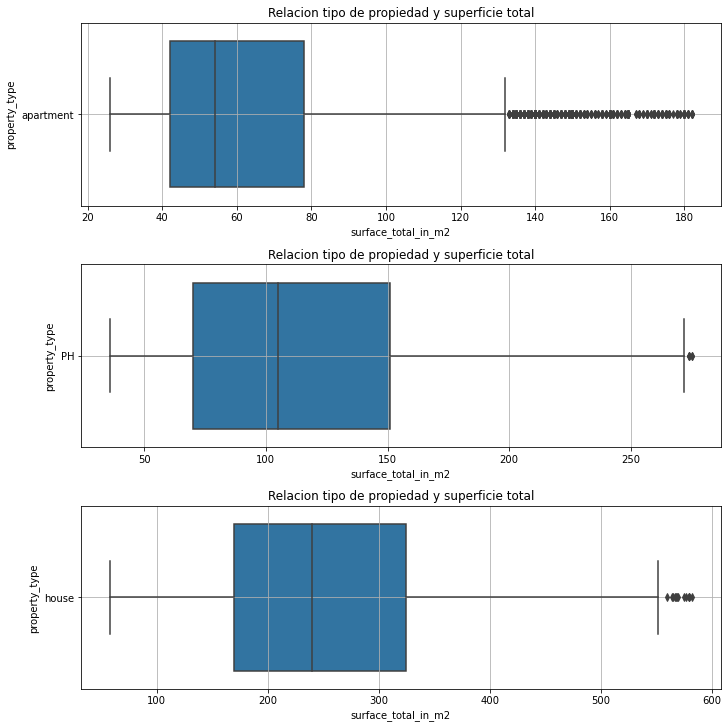

In [44]:
dptos= dptos[(dptos.surface_total_in_m2 <= 182.91) & (dptos.surface_total_in_m2 >=26.0) ]
phs=phs[(phs.surface_total_in_m2 <= 275.0) & (phs.surface_total_in_m2 >=35.0) ]
casas=casas[(casas.surface_total_in_m2 <= 583.12) & (casas.surface_total_in_m2 >=56.81) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y superficie total")
ax2.set_title("Relacion tipo de propiedad y superficie total")
ax3.set_title("Relacion tipo de propiedad y superficie total")
sns.boxplot(data=dptos,x="surface_total_in_m2",y="property_type",ax=ax1)
sns.boxplot(data=phs,x="surface_total_in_m2",y="property_type",ax=ax2)
sns.boxplot(data=casas,x="surface_total_in_m2",y="property_type",ax=ax3)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

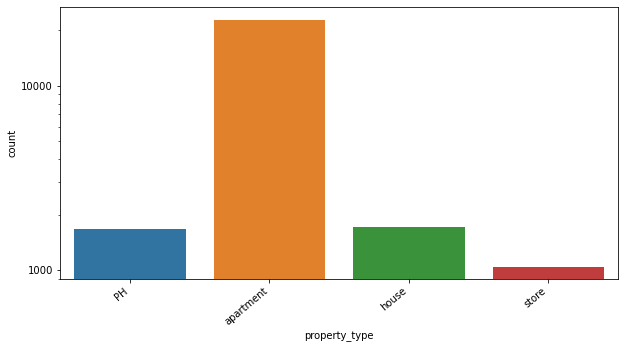

In [45]:
plt.figure(figsize=(10,5))
from matplotlib.ticker import ScalarFormatter

plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = propiedades_capital_surface_limpio, x = "property_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")


plt.show()

<AxesSubplot:>

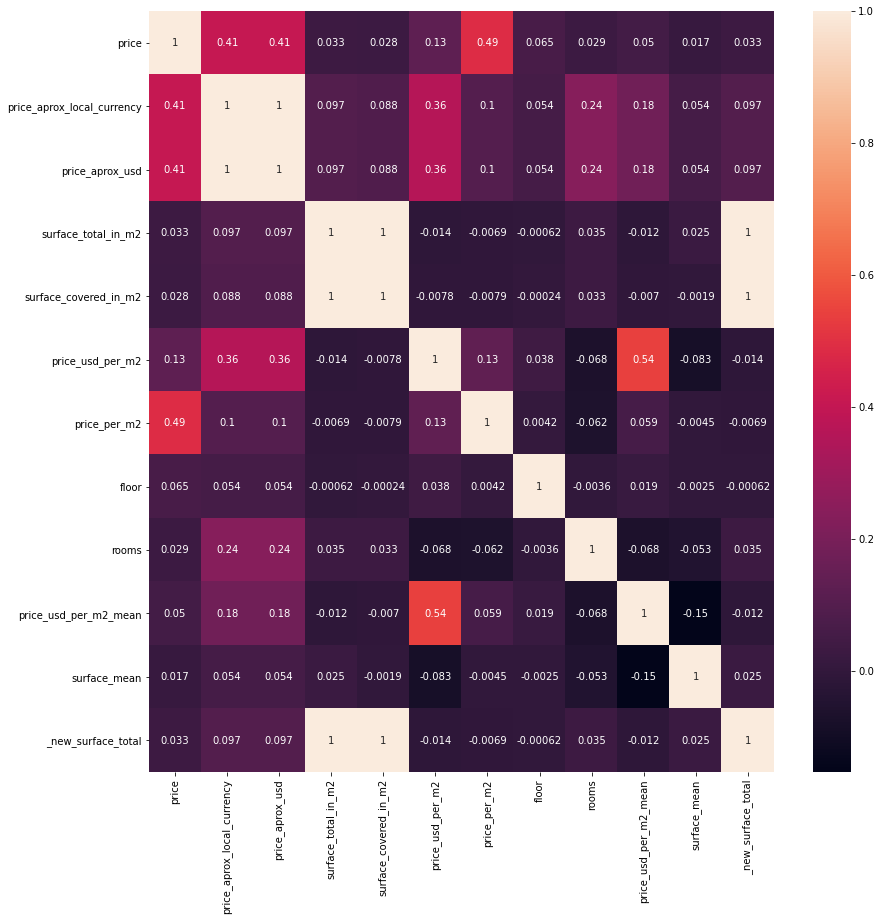

In [46]:
#Realizamos un heatmap para observar el grado de correlacion entre las variables
#propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.drop('surface_mean',axis=1)
#propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.drop('price_usd_per_m2_mean', axis=1)
fig =plt.subplots(figsize=(14,14))
sns.heatmap(propiedades_capital_surface_limpio.corr(), annot=True)

In [47]:
propiedades_capital_surface_limpio.dtypes


property_type                  object
place_name                     object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
description                    object
price_usd_per_m2_mean         float64
surface_mean                  float64
_new_surface_total            float64
dtype: object

In [48]:
propiedades_capital_surface_limpio.isna().sum()

property_type                     0
place_name                        0
price                             0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2               0
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      2
floor                         24467
rooms                             0
description                       0
price_usd_per_m2_mean             0
surface_mean                      0
_new_surface_total                0
dtype: int64

In [49]:
propiedades_capital_surface_limpio.isna().sum()

property_type                     0
place_name                        0
price                             0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2               0
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      2
floor                         24467
rooms                             0
description                       0
price_usd_per_m2_mean             0
surface_mean                      0
_new_surface_total                0
dtype: int64

In [50]:
dptos=propiedades_capital_surface_limpio_dptos[propiedades_capital_surface_limpio_dptos["property_type"]=="apartment"]
casas=propiedades_capital_surface_limpio_casas[propiedades_capital_surface_limpio_casas["property_type"]=="house"]
phs=propiedades_capital_surface_limpio_phs[propiedades_capital_surface_limpio_phs["property_type"]=="PH"]
stores=propiedades_capital_surface_limpio_stores[propiedades_capital_surface_limpio_stores["property_type"]=="store"]


In [51]:
from sklearn import *
X = dptos[['price','price_usd_per_m2', 'rooms', 'surface_total_in_m2','surface_covered_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y = dptos['price_aprox_usd']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print(model_fit_ridge_cv.alpha_)

print(model_fit_ridge_cv.best_score_)

0.3
0.9376249340631471


In [53]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

[ 1890.78964591 68209.16187681 -4133.64515637 93392.84351297
 14364.20599332]
190422.23444026505
0.938623099989803


In [54]:
model_fit_ridge.score(X_test, y_test)

0.9226594087244423

In [55]:
propiedades_capital_surface_limpio.property_type.value_counts()

apartment    22880
house         1722
PH            1676
store         1048
Name: property_type, dtype: int64

In [56]:
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean', '_new_surface_total'],
      dtype='object')

In [57]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2']].nlargest(5, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2
18070,apartment,Barrio Norte,210101.407740
13548,house,Liniers,12850.975566
16126,store,Villa Soldati,10958.000000
13471,apartment,Monte Castro,10282.610073
15643,apartment,Palermo,7897.341150


In [58]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2']].nlargest(5, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2
18070,apartment,Barrio Norte,210101.407740
13548,house,Liniers,12850.975566
16126,store,Villa Soldati,10958.000000
13471,apartment,Monte Castro,10282.610073
15643,apartment,Palermo,7897.341150


In [59]:
dptos[['price_usd_per_m2','property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10, columns='price_usd_per_m2')

,price_usd_per_m2,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
22044,6318.681319,apartment,Palermo,91.0,87.0
19757,6316.153846,apartment,Capital Federal,156.0,146.0
19793,6313.500000,apartment,Capital Federal,140.0,121.0
932,6307.692308,apartment,Palermo,52.0,52.0
10468,6304.347826,apartment,Palermo,92.0,89.0
25732,6304.347826,apartment,Puerto Madero,115.0,82.0
24587,6296.296296,apartment,Puerto Madero,135.0,130.0
5242,6285.714286,apartment,Belgrano,175.0,165.0
4640,6279.069767,apartment,Puerto Madero,86.0,86.0
12183,6255.319149,apartment,Puerto Madero,188.0,188.0


In [60]:
stores[['price_usd_per_m2']].describe()

,price_usd_per_m2
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [61]:
int(dptos[['price_usd_per_m2']].mean())

2707

In [62]:
(int(dptos[['price_usd_per_m2']].mean())+int(dptos[['price_usd_per_m2']].std())*2)

4373

# Scikit-Learn Metodología de trabajo

 Hay tres métricas de evaluación comunes para problemas de regresión:

** El error absoluto medio ** (MAE) es la media del valor absoluto de los errores:

$$ \frac 1n\sum_ {i = 1}^n |y_i-\hat{y}_i| $$

** Mean Squared Error ** (MSE) es la media de los errores al cuadrado:

$$ \frac 1n\sum_ {i = 1}^n(y_i- \hat{y}_i)^2 $$

** Error cuadrático medio raíz ** (RMSE) es la raíz cuadrada de la media de los errores al cuadrado:

$$ \sqrt{\frac 1n\sum_{i = 1}^n(y_i- \hat{y}_i)^2} $$

Comparando estas métricas:

- ** MAE **  es el error promedio.
- ** MSE **  "penaliza" errores grandes.
- ** RMSE **  es interpretable, tiene las mismas unidades  que la "y".
- ** $R^2$ ** es la proporción de la varianza total de $Y$ explicada por el modelo

Con excepción de R2, todas estas son ** funciones de pérdida **, porque queremos minimizarlas.


1) Seleccionar el modelo: Linear Regresion

In [63]:
#Importamos librerias
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model

2) Elegir los hiperparámetros Dejo los default

3) Presentar los datos en una matriz de features y un vestot traget

In [64]:
#df_clean=propiedades_capital_surface_limpio[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
df_clean=propiedades_capital_surface_limpio_dptos[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=propiedades_capital_surface_limpio_casas[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=propiedades_capital_surface_limpio_phs[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]


In [65]:
from sklearn import preprocessing

X = preprocessing.scale(df_clean.drop(['price_usd_per_m2'], axis=1))
Y = preprocessing.scale(df_clean['price_usd_per_m2'])

In [66]:
X=df_clean.drop(['price_usd_per_m2'], axis=1)
#X=df_clean2['price']
Y=df_clean['price_usd_per_m2']

In [67]:
#instanciamos el modelo
lm = linear_model.LinearRegression()

4) Separamos set de entrenamiento y testing

In [68]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)

5) Ajustamos el modelo a los datos de entrenamiento

In [69]:
model_lr=lm.fit(X,Y)

6) Predecimos etiquetas para datos desconocidos

In [70]:
y_pred=lm.predict(X_test_2)

7) Evaluamos performance del modelo

In [71]:
#no me funcionó
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test_2,y_pred)

In [72]:
#score del modelo de entrenamiento
model_lr.score(X_train_2,y_train_2)

0.8007946396285532

In [73]:

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [74]:
X8 = preprocessing.scale(df_clean.drop(['price_usd_per_m2'], axis=1))
Y8 = preprocessing.scale(df_clean['price_usd_per_m2'])

X8=df_clean.drop(['price_usd_per_m2'], axis=1)
#X=df_clean2['price']
Y8=df_clean['price_usd_per_m2']

X8_train, X8_test, Y8_train, Y8_test = train_test_split(X8, Y8, test_size=0.30, random_state=42)
lr = linear_model.LinearRegression()
cv = KFold(5, shuffle=True)
scores = cross_val_score(lr, X8_train, Y8_train, cv=cv, scoring='r2')
scores, scores.mean()

(array([0.81209302, 0.79238726, 0.80188484, 0.80725348, 0.80372051]),
 0.8034678199386442)

LASSO

In [75]:
model = linear_model.LassoCV().fit(X8_train, Y8_train)
scores = cross_val_score(model, X8_train, Y8_train, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 70402.40063371556,
 'scores': array([0.39319033, 0.42085261, 0.35510551, 0.41638331, 0.39870487]),
 'mean_score': 0.3968473253751163,
 'zero_coefs': 3}

LASSO

In [76]:
model = linear_model.LassoCV(normalize=True).fit(X8, Y8)
scores = cross_val_score(model, X8, Y8, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.03461975781814337,
 'scores': array([0.80213916, 0.80797277, 0.8050143 , 0.78783812, 0.80063029]),
 'mean_score': 0.8007189282205793,
 'zero_coefs': 0}

RIDGE

In [77]:
model = linear_model.RidgeCV(normalize=True).fit(X8, Y8)
scores = cross_val_score(model, X8, Y8, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean())

{'alpha': 0.1,
 'scores': array([0.73315906, 0.72259339, 0.72744654, 0.70451606, 0.61220843]),
 'mean_score': 0.6999846949491746}

In [78]:

from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV



LASSO DEPARTAMENTOS

In [79]:
X_d = dptos[['price','price_usd_per_m2', 'rooms', 'surface_total_in_m2','surface_covered_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X_d)

y_d = dptos['price_aprox_usd']

In [80]:
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_std, y_d, test_size = 0.3, random_state = 117)

model_lasso_cv = linear_model.LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)

model_fit_lasso_cv = model_lasso_cv.fit(X_d_train, y_d_train)

print(model_fit_lasso_cv.alpha_)

#print(model_fit_lasso_cv.best_score_)

2.3240894323708225


In [81]:
best_alpha = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_lasso = model_ridge.fit(X_d_train, y_d_train)
print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)
print(model_fit_lasso.score(X_d_train, y_d_train))

[ 1890.78964591 68209.16187681 -4133.64515637 93392.84351297
 14364.20599332]
190422.23444026505
0.938623099989803


In [82]:
model_fit_lasso.score(X_d_test, y_d_test)

0.9226594087244423

LASSO CASAS

In [83]:
X_c = casas[['price','price_usd_per_m2', 'rooms', 'surface_total_in_m2','surface_covered_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X_c)

y_c = casas['price_aprox_usd']

In [84]:
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_std, y_c, test_size = 0.3, random_state = 117)

model_lasso_cv = linear_model.LassoCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 1100.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_lasso_cv = model_lasso_cv.fit(X_c_train, y_c_train)

print(model_fit_lasso_cv.alpha_)

#print(model_fit_lasso_cv.best_score_)

1.4


In [85]:
best_alpha = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_lasso = model_ridge.fit(X_c_train, y_c_train)
print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)
print(model_fit_lasso.score(X_c_train, y_c_train))

[ 37389.1115915  158518.2994493    -674.94423106 169903.85206532
  80200.99245389]
450496.47765156464
0.8726634178731126


In [86]:
model_fit_lasso.score(X_c_test, y_c_test)

0.8719423808878817

PHS


In [87]:
X_p = phs[['price','price_usd_per_m2', 'rooms', 'surface_total_in_m2','surface_covered_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X_p)

y_p = phs['price_aprox_usd']

In [88]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_std, y_p, test_size = 0.3, random_state = 117)

model_lasso_cv = linear_model.LassoCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 1100.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_lasso_cv = model_lasso_cv.fit(X_p_train, y_p_train)

print(model_fit_lasso_cv.alpha_)

#print(model_fit_lasso_cv.best_score_)

0.3


In [89]:
best_alpha = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_lasso = model_ridge.fit(X_p_train, y_p_train)
print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)
print(model_fit_lasso.score(X_p_train, y_p_train))

[7.93181948e+04 2.76589972e+02 1.34257203e+00 4.47006098e+02
 3.73253561e+01]
181999.72035830235
0.999997412329074


In [90]:
model_fit_lasso.score(X_p_test, y_p_test)

0.9999974685639783

Probamos con U$S/m2 vs Precio

In [91]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


#X_2 = preprocessing.scale(df_clean['price_aprox_usd'])
X_2=df_clean[['price_aprox_usd']]
#Y=df_clean[['price_usd_per_m2']]
#X_2_train, X_2test, Y_train, Y_test = train_test_split(X_2,Y, random_state=1)
#instanciamos el modelo
lm_2 = linear_model.LinearRegression()


model_lr_2=lm_2.fit(X_2,Y)

y_pred_2=lm_2.predict(X_2)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model_lr_2.intercept_)
print ('RM=', ' ', model_lr_2.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', model_lr_2.score(X_2, Y))

Intercepto=   1970.439892946251
RM=   [0.00386958]
R2_train=   0.4054287385602635


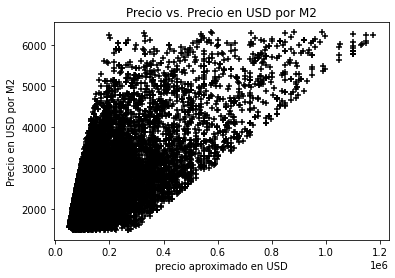

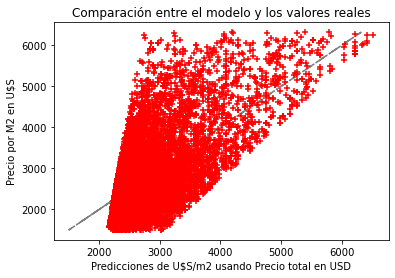

In [92]:

# Graficamos la variable X contra la variable Y
plt.scatter(X_2, Y, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_2, Y)
plt.xlabel("precio aproximado en USD")
plt.ylabel("Precio en USD por M2")
plt.title('Precio vs. Precio en USD por M2')
plt.show()

#Graficamos el modelo
plt.plot(Y,Y, '-.',c='grey')
plt.scatter(y_pred_2, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de U$S/m2 usando Precio total en USD")
plt.ylabel("Precio por M2 en U$S")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()

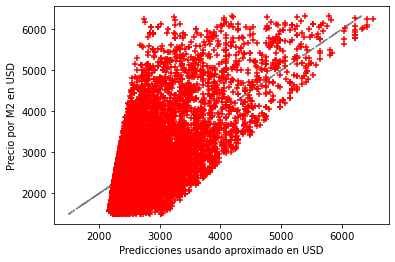

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                 1.055e+04
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:16:16   Log-Likelihood:            -1.2205e+05
No. Observations:               15479   AIC:                         2.441e+05
Df Residuals:                   15477   BIC:                         2.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1970.4399      8.844    2

In [93]:
# Importamos la api.
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

X_2=df_clean[['price_aprox_usd']]

X_2 = sm.add_constant(X_2)

model2 = sm.OLS(Y, X_2).fit()
predictions2 = model2.predict(X_2)


plt.plot(Y,Y, '-.', c='grey')
plt.scatter(predictions2, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando aproximado en USD")
plt.ylabel("Precio por M2 en USD")
plt.show()


#print ("EMC:", mean_squared_error(Y, predictions2))
print (model2.summary())

Pruebo con precio/m2 vs surface_total

In [94]:
X_3=df_clean[['surface_total_in_m2']]
#Y_3=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_3 = linear_model.LinearRegression()

#X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_3,Y_3, random_state=1)

model_lr_3=lm_3.fit(X_3,Y)

y_pred_3=lm_3.predict(X_3)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model_lr_3.intercept_)
print ('RM=', ' ', model_lr_3.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', model_lr_3.score(X_3, Y))

Intercepto=   2420.101807771488
RM=   [4.19957684]
R2_train=   0.031063377769220413


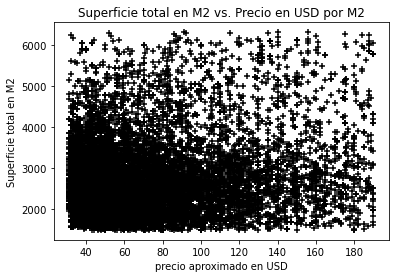

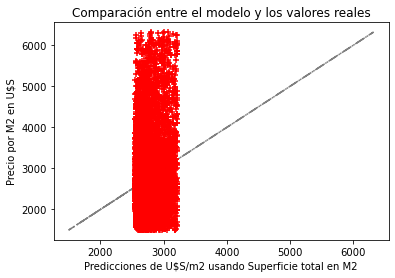

In [95]:

# Graficamos la variable X contra la variable Y
plt.scatter(X_3, Y, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_2, Y)
plt.xlabel("precio aproximado en USD")
plt.ylabel("Superficie total en M2")
plt.title('Superficie total en M2 vs. Precio en USD por M2')
plt.show()

#Graficamos el modelo
plt.plot(Y,Y, '-.',c='grey')
plt.scatter(y_pred_3, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de U$S/m2 usando Superficie total en M2")
plt.ylabel("Precio por M2 en U$S")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()

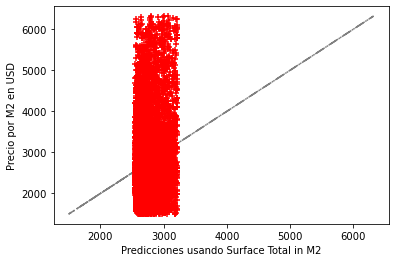

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     496.2
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          3.21e-108
Time:                        11:16:16   Log-Likelihood:            -1.2583e+05
No. Observations:               15479   AIC:                         2.517e+05
Df Residuals:                   15477   BIC:                         2.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2420.1018    

In [96]:

X_3=df_clean[['surface_total_in_m2']]
X_3 = sm.add_constant(X_3)

model3 = sm.OLS(Y, X_3).fit()
predictions3 = model3.predict(X_3)


plt.plot(Y,Y, '-.', c='grey')
plt.scatter(predictions3, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando Surface Total in M2")
plt.ylabel("Precio por M2 en USD")
plt.show()


#print ("EMC:", mean_squared_error(Y, predictions3))
print (model3.summary())

Pruebo con precio/m2 vs surface_covered

In [97]:
X_4=df_clean[['surface_covered_in_m2']]
#Y_3=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_4 = linear_model.LinearRegression()

#X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_3,Y_3, random_state=1)

model_lr_4=lm_3.fit(X_4,Y)

y_pred_4=lm_3.predict(X_4)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model_lr_4.intercept_)
print ('RM=', ' ', model_lr_4.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', model_lr_4.score(X_4, Y))

Intercepto=   2528.561405475791
RM=   [2.93832503]
R2_train=   0.023687783186552402


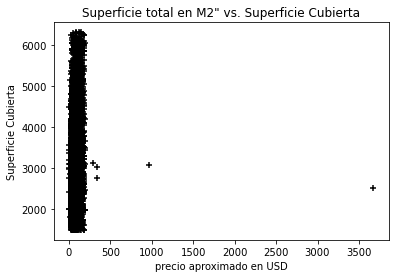

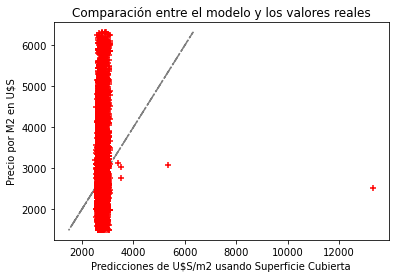

In [98]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_4, Y, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_2, Y)
plt.xlabel("precio aproximado en USD")
plt.ylabel("Superficie Cubierta")
plt.title('Superficie total en M2" vs. Superficie Cubierta')
plt.show()

#Graficamos el modelo
plt.plot(Y,Y, '-.',c='grey')
plt.scatter(y_pred_4, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de U$S/m2 usando Superficie Cubierta")
plt.ylabel("Precio por M2 en U$S")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()

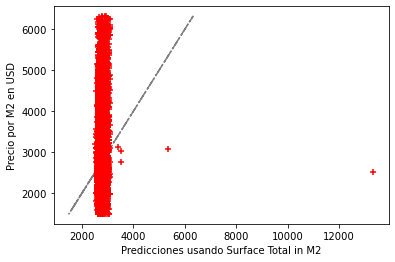

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     375.5
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           1.12e-82
Time:                        11:16:17   Log-Likelihood:            -1.2589e+05
No. Observations:               15479   AIC:                         2.518e+05
Df Residuals:                   15477   BIC:                         2.518e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2528.56

In [99]:
X_4=df_clean[['surface_covered_in_m2']]
X_4 = sm.add_constant(X_4)

model4 = sm.OLS(Y, X_4).fit()
predictions4 = model4.predict(X_4)


plt.plot(Y,Y, '-.', c='grey')
plt.scatter(predictions4, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando Surface Total in M2")
plt.ylabel("Precio por M2 en USD")
plt.show()


#print ("EMC:", mean_squared_error(Y, predictions4))
print (model4.summary())

In [100]:
X_4=df_clean[['surface_covered_in_m2']]
Y_4=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_4 = linear_model.LinearRegression()

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_4,Y_4, random_state=1)

model_lr_4=lm_4.fit(X_4,Y_4)

y_pred_4=lm_4.predict(X_test_5)

model_lr_4.score(X_train_5,y_train_5)

0.018880010881708764

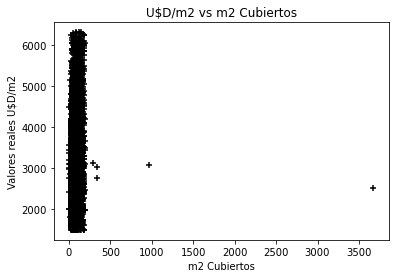

In [101]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_4, Y_4, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_4, Y_4)
plt.xlabel("m2 Cubiertos")
plt.ylabel("Valores reales U$D/m2")
plt.title('U$D/m2 vs m2 Cubiertos')
plt.show()

Pruebo con precio/m2 vs room

In [102]:
X_5=df_clean[['rooms']]
Y_5=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_5 = linear_model.LinearRegression()

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_5,Y_5, random_state=1)

model_lr_5=lm_5.fit(X_5,Y_5)

y_pred_5=lm_5.predict(X_test_6)

model_lr_5.score(X_train_6,y_train_6)

0.0022282410927234597

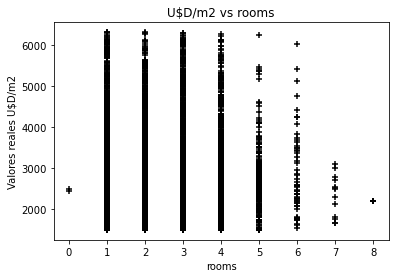

In [103]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_5, Y_5, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_4, Y_4)
plt.xlabel("rooms")
plt.ylabel("Valores reales U$D/m2")
plt.title('U$D/m2 vs rooms')
plt.show()

In [104]:
X_5=df_clean[['rooms']]
#Y_3=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_5 = linear_model.LinearRegression()

#X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_3,Y_3, random_state=1)

model_lr_5=lm_5.fit(X_5,Y)

y_pred_5=lm_5.predict(X_5)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model_lr_5.intercept_)
print ('RM=', ' ', model_lr_5.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', model_lr_5.score(X_5, Y))

Intercepto=   2629.9947638350727
RM=   [37.18573852]
R2_train=   0.0027678883575502633


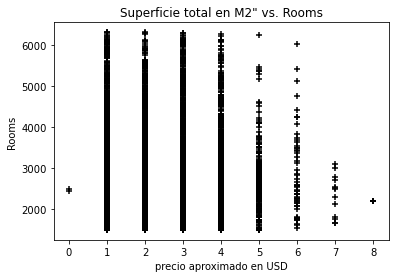

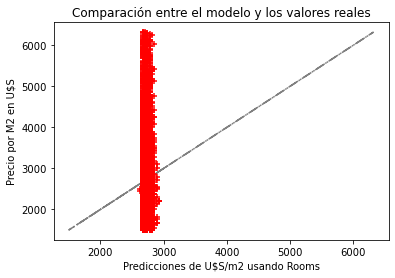

In [105]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_5, Y, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_2, Y)
plt.xlabel("precio aproximado en USD")
plt.ylabel("Rooms")
plt.title('Superficie total en M2" vs. Rooms')
plt.show()

#Graficamos el modelo
plt.plot(Y,Y, '-.',c='grey')
plt.scatter(y_pred_5, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de U$S/m2 usando Rooms")
plt.ylabel("Precio por M2 en U$S")
plt.title('Comparación entre el modelo y los valores reales')
plt.show()

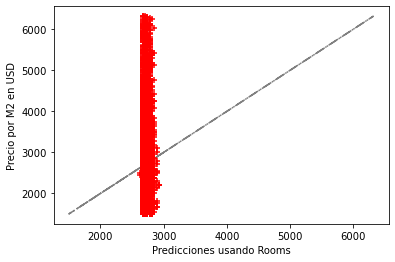

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     42.96
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           5.77e-11
Time:                        11:16:18   Log-Likelihood:            -1.2606e+05
No. Observations:               15479   AIC:                         2.521e+05
Df Residuals:                   15477   BIC:                         2.521e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2629.9948     13.601    193.365      0.0

In [106]:
X_5=df_clean[['rooms']]
X_5 = sm.add_constant(X_5)

model5 = sm.OLS(Y, X_5).fit()
predictions5 = model5.predict(X_5)


plt.plot(Y,Y, '-.', c='grey')
plt.scatter(predictions5, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando Rooms")
plt.ylabel("Precio por M2 en USD")
plt.show()


#print ("EMC:", mean_squared_error(Y, predictions5))
print (model5.summary())

In [107]:
stores[['price_usd_per_m2']].describe()

,price_usd_per_m2
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [108]:
from sklearn import *
from scipy import stats
import statsmodels.api as sm
for i in lista_barrios:
    
    globals()['dptos_barrio%s' % i]=propiedades_capital_surface_limpio_dptos[propiedades_capital_surface_limpio_dptos["place_name"]==i]
    
    df_dptos_barrios=globals()['dptos_barrio%s' % i]
    df_dptos_barrios=df_dptos_barrios[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
    X=df_dptos_barrios.drop(['price_usd_per_m2'], axis=1)
    #X=df_clean2['price']
    Y=df_dptos_barrios['price_usd_per_m2']
    lm = linear_model.LinearRegression()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)
    model_lr=lm.fit(X,Y)
    y_pred=lm.predict(X_test_2)
    
    
    X2= sm.add_constant(X)
    est= sm.OLS(Y, X2)
    est2= est.fit()
    
    erre2=(model_lr.score(X_train_2,y_train_2))
    fit_ridge_alpha=model_fit_ridge_cv.alpha_
    fit_best_score=model_fit_ridge_cv.best_score_
    sumario=est2.summary()
    
    ########
    X2 = df_dptos_barrios[['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
    scaler = StandardScaler()
    X_std_2 = scaler.fit_transform(X2)

    y_2 = df_dptos_barrios['price_aprox_usd']

    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_std_2, y_2, test_size = 0.3, random_state = 117)

    model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)
    model_fit_ridge_cv = model_ridge_cv.fit(X_train_2, y_train_2)


    best_alpha = model_fit_ridge_cv.alpha_
    model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
    #print("Modelo: "+str(model_fit_ridge_cv))
    print("Modelo: "+str(model_fit_ridge_cv.coef_))

########
    ############
    print("Para departamentos en el barrio " + str(i) + " el R2 es: "+str(erre2))
    print("Grado de significancia : "+str(fit_ridge_alpha))
    print(fit_best_score)
    #print("El modelo de datos sería " + str(model_fit_ridge.score(X_train, y_train)))      
    print(sumario)
    print("")
plt.plot(Y,Y, '-.', c='grey')
plt.scatter(y_pred, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Variable Predictora")
plt.ylabel("Precio por M2 en USD")
plt.show()

Modelo: [57278.84875517  1049.02735486   902.33675432  -204.36997501]
Para departamentos en el barrio Mataderos el R2 es: 0.9192348758104002
Grado de significancia : 0.3
0.9376249340631471
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     132.1
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           9.60e-31
Time:                        11:16:18   Log-Likelihood:                -449.91
No. Observations:                  71   AIC:                             909.8
Df Residuals:                      66   BIC:                             921.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     

Modelo: [7.15469779e+04 3.40262199e+02 1.22048228e+01 1.36508817e+01]
Para departamentos en el barrio Flores el R2 es: 0.8072520186005672
Grado de significancia : 0.3
0.9999995870483401
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     728.7
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          1.89e-245
Time:                        11:16:19   Log-Likelihood:                -4400.2
No. Observations:                 692   AIC:                             8810.
Df Residuals:                     687   BIC:                             8833.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        

strong multicollinearity or other numerical problems.

Modelo: [ 5.67733574e+04  4.77056691e+02 -8.15474899e+00 -3.32790421e+01]
Para departamentos en el barrio Balvanera el R2 es: 0.8405064519732776
Grado de significancia : 0.3
0.9999263935984283
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     394.3
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          1.10e-115
Time:                        11:16:20   Log-Likelihood:                -1899.3
No. Observations:                 294   AIC:                             3809.
Df Residuals:                     289   BIC:                             3827.
Df Model:                           4                                         
Covariance Type:            nonrobust    

Modelo: [ 1.75579418e+05  2.41879616e+02  5.40394098e+02 -8.81242097e+01]
Para departamentos en el barrio Capital Federal el R2 es: 0.8402658520333884
Grado de significancia : 0.3
0.9999968957485998
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     471.2
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          5.47e-123
Time:                        11:16:21   Log-Likelihood:                -2079.9
No. Observations:                 285   AIC:                             4170.
Df Residuals:                     280   BIC:                             4188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
           

Modelo: [7.43945167e+04 5.30643623e+02 1.54966349e+02 5.04953656e+01]
Para departamentos en el barrio Barracas el R2 es: 0.8969698321703005
Grado de significancia : 0.3
0.9999981284266222
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     426.6
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          2.81e-101
Time:                        11:16:22   Log-Likelihood:                -1436.7
No. Observations:                 221   AIC:                             2883.
Df Residuals:                     216   BIC:                             2900.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      

Modelo: [5.62121760e+04 6.26515221e+02 2.24712953e+02 5.39148185e+01]
Para departamentos en el barrio Chacarita el R2 es: 0.8984430186348822
Grado de significancia : 0.3
0.9999971265549291
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     264.5
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           1.49e-60
Time:                        11:16:23   Log-Likelihood:                -832.65
No. Observations:                 132   AIC:                             1675.
Df Residuals:                     127   BIC:                             1690.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     

Modelo: [6.24566540e+04 2.28933182e+02 1.50018561e+02 6.39100311e+00]
Para departamentos en el barrio Saavedra el R2 es: 0.8330628342239088
Grado de significancia : 0.3
0.9999894172870551
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     363.1
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          5.71e-117
Time:                        11:16:24   Log-Likelihood:                -2166.1
No. Observations:                 322   AIC:                             4342.
Df Residuals:                     317   BIC:                             4361.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning:

divide by zero encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning:

invalid value encountered in double_scalars

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning:

divide by zero encountered in double_scalars



ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=1.

In [ ]:
##### BLOQUE DE CODIGO - R2 Y PVALUE PARA CASAS POR BARRIO ####
"""for i in lista_barrios:
    
    globals()['casas_barrio%s' % i]=propiedades_capital_surface_limpio_casas[propiedades_capital_surface_limpio_casas["place_name"]==i]
    df_clean=globals()['casas_barrio%s' % i]
    #df_clean=casas[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2']]
    df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
    X=df_clean.drop(['price_usd_per_m2'], axis=1)
    #X=df_clean2['price']
    Y=df_clean['price_usd_per_m2']
    lm = linear_model.LinearRegression()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)
    model_lr=lm.fit(X,Y)
    y_pred=lm.predict(X_test_2)
    
    X2= sm.add_constant(X)
    est= sm.OLS(Y, X2)
    est2= est.fit()
    #price_usd_place_rooms = df_clean["price_usd_per_m2"][df_clean["rooms"]==1]
    #price_usd_price= df_clean["price_usd_per_m2"][df_clean["price_aprox_usd"]==]
    #HamDEnfermedad3 = datos["Ham-D"][datos["Enfermedad"]
    #print("El valor de P-test: "+str(stats.ttest_rel(price_usd_place_rooms, price_usd_price)))
    
    print("Para casas en el barrio " + str(i) + " el R2 es: "+str(model_lr.score(X_train_2,y_train_2)))
    print(est2.summary())
    print("")  
    """

#### BLOQUE DE CODIGO DE R2 Y PVALUES PARA CASAS TOTALES ####

df_clean=casas[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
X=df_clean.drop(['price_usd_per_m2'], axis=1)
#X=df_clean2['price']
Y=df_clean['price_usd_per_m2']
lm = linear_model.LinearRegression()
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,Y, random_state=1)
model_lr=lm.fit(X,Y)
y_pred=lm.predict(X_test_1)

########
X2 = casas[['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]

scaler = StandardScaler()

X_std_2 = scaler.fit_transform(X2)

y_2 = casas['price_aprox_usd']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_std_2, y_2, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)
model_fit_ridge_cv = model_ridge_cv.fit(X_train_2, y_train_2)


best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
#print("Modelo: "+str(model_fit_ridge_cv))
print("Modelo: "+str(model_fit_ridge_cv.coef_))

########
    
#X2= sm.add_constant(X)
#est= sm.OLS(Y, X2)
#est2= est.fit()

print("Para casas el R2 es: "+str(model_lr.score(X_train_1,y_train_1)))
print(est2.summary())
print("") 


In [ ]:
##### BLOQUE DE CODIGO - R2 Y PVALUE PARA PHS POR BARRIO ####
"""for i in lista_barrios:
    
    globals()['casas_barrio%s' % i]=propiedades_capital_surface_limpio_casas[propiedades_capital_surface_limpio_casas["place_name"]==i]
    df_clean=globals()['casas_barrio%s' % i]
    #df_clean=casas[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2']]
    df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
    X=df_clean.drop(['price_usd_per_m2'], axis=1)
    #X=df_clean2['price']
    Y=df_clean['price_usd_per_m2']
    lm = linear_model.LinearRegression()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)
    model_lr=lm.fit(X,Y)
    y_pred=lm.predict(X_test_2)
    
    X2= sm.add_constant(X)
    est= sm.OLS(Y, X2)
    est2= est.fit()
    #price_usd_place_rooms = df_clean["price_usd_per_m2"][df_clean["rooms"]==1]
    #price_usd_price= df_clean["price_usd_per_m2"][df_clean["price_aprox_usd"]==]
    #HamDEnfermedad3 = datos["Ham-D"][datos["Enfermedad"]
    #print("El valor de P-test: "+str(stats.ttest_rel(price_usd_place_rooms, price_usd_price)))
    
    print("Para casas en el barrio " + str(i) + " el R2 es: "+str(model_lr.score(X_train_2,y_train_2)))
    print(est2.summary())
    print("")  
    """

#### BLOQUE DE CODIGO DE R2 Y PVALUES PARA PHS TOTALES ####

df_clean=phs[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
X3=df_clean.drop(['price_usd_per_m2'], axis=1)
#X=df_clean2['price']
Y3=df_clean['price_usd_per_m2']
lm3 = linear_model.LinearRegression()
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3,Y3, random_state=1)
model_lr=lm3.fit(X3,Y3)
y_pred=lm3.predict(X_test_3)

########
X4 = phs[['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]

scaler = StandardScaler()

X_std_4 = scaler.fit_transform(X4)

y_4 = phs['price_aprox_usd']

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_std_4, y_4, test_size = 0.3, random_state = 117)

model_ridge_cv4 = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)
model_fit_ridge_cv4 = model_ridge_cv4.fit(X_train_4, y_train_4)


best_alpha4 = model_fit_ridge_cv4.alpha_
model_ridge4 = linear_model.Ridge(alpha = best_alpha4, fit_intercept = True, normalize = False)
#print("Modelo: "+str(model_fit_ridge_cv))
print("Modelo: "+str(model_fit_ridge_cv4.coef_))

########
    
#X2= sm.add_constant(X)
#est= sm.OLS(Y, X2)
#est2= est.fit()

print("Para phs el R2 es: "+str(model_lr.score(X_train_3,y_train_3)))
print(est2.summary())
print("") 


In [ ]:
casas.shape

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(12,8))
sns.heatmap(df_clean.corr(), annot = True,vmin=-1, vmax=1, center= 0,cmap= 'coolwarm',linewidths=3, linecolor='black',ax=ax1)

♦ Seleccionar las variables predictoras (X) y la variable a predecir (y).

In [ ]:
X12 = df_clean[["price_aprox_usd","surface_covered_in_m2","surface_total_in_m2","rooms"]]
y12 = df_clean["price_usd_per_m2"]

♦ Realizar un Train/Test split de los datos.

In [ ]:
X12_train,X12_test,y12_train,y12_test= train_test_split(X12,y12,test_size=0.30,random_state=42)

♦ Generar un modelo benchmark y evaluarlo.

In [ ]:
regressor = LinearRegression()

In [ ]:
regressor.fit(X12_train,y12_train)

In [ ]:
y_train_pred = regressor.predict(X12_train)
y_test_pred = regressor.predict(X12_test)

In [ ]:
from sklearn.metrics import mean_absolute_error

MAE_train=mean_absolute_error(y12_train,y_train_pred)
MAE_test=mean_absolute_error(y12_test,y_test_pred)

RMSE_train=np.sqrt(mean_squared_error(y12_train,y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y12_test,y_test_pred))

r2_train= metrics.r2_score(y12_train, y_train_pred)
r2_test= metrics.r2_score(y12_test, y_test_pred)

adj_r2_train = 1 - ((1 - r2_train) * (len(y12_train) - 1)) / (len(y_train) - X12_train.shape[1] - 1)
adj_r2_test = 1 - ((1 - r2_test) * (len(y12_test) - 1)) / (len(y_test) - X12_test.shape[1] - 1)
    

print("El MAE en train es:",MAE_train)
print("El MAE en test es:",MAE_test)
print("-------------------------------------------")
print("El RMSE en train es:",RMSE_train)
print("El RMSE en test es:",RMSE_test)
print("-------------------------------------------")
print("El r2 de train es:",r2_train)
print("El r2 de test es:",r2_test)
print("-------------------------------------------")
print("El r2 ajustado de train es:",adj_r2_train)
print("El r2 ajustado de test es:",adj_r2_test)

♦ Entrenar un modelo de vecinos más cercanos y un modelo de árbol de decisión con hiperparámetros iniciales de su elección.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
arbol_regressor = DecisionTreeRegressor(random_state=42)
knn_regressor = KNeighborsRegressor()

In [ ]:
arbol_regressor.fit(X12_train,y12_train)
knn_regressor.fit(X12_train,y12_train)

In [ ]:
y_arbol_pred_train = arbol_regressor.predict(X12_train)
y_arbol_pred_test = arbol_regressor.predict(X12_test)

y_knn_pred_train = knn_regressor.predict(X12_train)
y_knn_pred_test = knn_regressor.predict(X12_test)

--> Metricas para arbol y knn

--> Arbol de regresion

In [ ]:
arbol_MAE_train=mean_absolute_error(y12_train,y_arbol_pred_train)
arbol_MAE_test=mean_absolute_error(y12_test,y_arbol_pred_test)

arbol_RMSE_train=np.sqrt(mean_squared_error(y12_train,y_arbol_pred_train))
arbol_RMSE_test=np.sqrt(mean_squared_error(y12_test,y_arbol_pred_test))

arbol_r2_train= metrics.r2_score(y12_train, y_arbol_pred_train)
arbol_r2_test= metrics.r2_score(y12_test, y_arbol_pred_test)

arbol_adj_r2_train = 1 - ((1 - arbol_r2_train) * (len(y12_train) - 1)) / (len(y12_train) - X12_train.shape[1] - 1)
arbol_adj_r2_test = 1 - ((1 - arbol_r2_test) * (len(y12_test) - 1)) / (len(y12_test) - X12_test.shape[1] - 1)
    

print("El MAE en train es:",arbol_MAE_train)
print("El MAE en test es:",arbol_MAE_test)
print("-------------------------------------------")
print("El RMSE en train es:",arbol_RMSE_train)
print("El RMSE en test es:",arbol_RMSE_test)
print("-------------------------------------------")
print("El r2 de train es:",arbol_r2_train)
print("El r2 de test es:",arbol_r2_test)
print("-------------------------------------------")
print("El r2 ajustado de train es:",arbol_adj_r2_train)
print("El r2 ajustado de test es:",arbol_adj_r2_test)

--> Knn

In [ ]:
knn_MAE_train=mean_absolute_error(y12_train,y_knn_pred_train)
knn_MAE_test=mean_absolute_error(y12_test,y_knn_pred_test)

knn_RMSE_train=np.sqrt(mean_squared_error(y12_train,y_knn_pred_train))
knn_RMSE_test=np.sqrt(mean_squared_error(y12_test,y_knn_pred_test))

knn_r2_train= metrics.r2_score(y12_train, y_knn_pred_train)
knn_r2_test= metrics.r2_score(y12_test, y_knn_pred_test)

knn_adj_r2_train = 1 - ((1 - knn_r2_train) * (len(y12_train) - 1)) / (len(y12_train) - X12_train.shape[1] - 1)
knn_adj_r2_test = 1 - ((1 - knn_r2_test) * (len(y12_test) - 1)) / (len(y12_test) - X12_test.shape[1] - 1)
    

print("El MAE en train es:",knn_MAE_train)
print("El MAE en test es:",knn_MAE_test)
print("-------------------------------------------")
print("El RMSE en train es:",knn_RMSE_train)
print("El RMSE en test es:",knn_RMSE_test)
print("-------------------------------------------")
print("El r2 de train es:",knn_r2_train)
print("El r2 de test es:",knn_r2_test)
print("-------------------------------------------")
print("El r2 ajustado de train es:",knn_adj_r2_train)
print("El r2 ajustado de test es:",knn_adj_r2_test)

♦ Evaluar los modelos obtenidos. Para ello, evalúa la métrica elegida en el conjunto de Test y en el conjunto de Train. También, realiza gráficos de valores reales vs. valores predichos.

In [ ]:
models = ['Regresión lineal', 'Vecinos más cercanos']

for i, model in enumerate([regressor, knn_regressor]):
    y_train_pred = model.predict(X12_train)
    y_test_pred = model.predict(X12_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y12_train, y_train_pred)
    r2_test= metrics.r2_score(y12_test, y_test_pred)
    
    adj_r2_train = 1 - ((1 - r2_train) * (len(y12_train) - 1)) / (len(y12_train) - X12_train.shape[1] - 1)
    adj_r2_test = 1 - ((1 - r2_test) * (len(y12_test) - 1)) / (len(y12_test) - X12_test.shape[1] - 1)
    
    RMSE_train=np.sqrt(mean_squared_error(y12_train,y_train_pred))
    RMSE_test=np.sqrt(mean_squared_error(y12_test,y_test_pred))

    print("R2 en Train:", r2_train)
    print("R2 ajustado en train:", adj_r2_train)
    print("--------------------------")
    print("R2 en test:", r2_test)
    print("R2 ajustado en Test:", adj_r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y12_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y12 (test)')
    plt.ylabel('y12_pred (test)')
    
    plt.tight_layout()
    plt.show()